In [1]:
pwd

'/Users/aidasaglinskas/Desktop/BC-FacExpr-1.2-fMRI-mainExp/scripts_python'

In [2]:
#skvideo.setFFmpegPath("/Users/aidasaglinskas/Desktop/test/")

In [3]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def safe_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [6]:
def brighten_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Brightness(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [7]:
def contrast_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Contrast(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [8]:
def save_video(videodata,ofn='outvideo.mp4'):
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [9]:
def make_ref(ctargets):
    ref = np.ones((10,10,3))
    for i in range(3):
        ref[:,:,i] = ref[:,:,i] * ctargets[i]
    return ref.astype(np.uint8)

In [10]:
def get_face(frame,l=50):
    return frame[256-l:256+l,256-l:256+l,:]

In [11]:
def get_mean_rbg(frame):
    return frame.mean(axis=0).mean(axis=0)

In [12]:
def tint_frame_face(frame,ctargets):
    
    face_square = get_face(frame)
    diff = get_mean_rbg(face_square)-ctargets
    frame_copy = frame.astype(np.float64)
    for i in range(3):
        frame_copy[:,:,i] = frame_copy[:,:,i] - diff[i]
        frame_copy[frame_copy<0]=0
        frame_copy[frame_copy>255]=255
        
    frame_copy = frame_copy.astype(np.uint8)
    return frame_copy

In [13]:
def tint_video_face(videodata,ctargets):
    nframes = videodata.shape[0]
    tinted_video = np.array([tint_frame_face(videodata[i,:,:,:],ctargets) for i in range(nframes)])
    return tinted_video

In [14]:
def tint_frame(frame,ctargets):
    
    #face_square = get_face(frame)
    diff = get_mean_rbg(frame)-ctargets
    frame_copy = frame.astype(np.float64)
    for i in range(3):
        frame_copy[:,:,i] = frame_copy[:,:,i] - diff[i]
        frame_copy[frame_copy<0]=0
        frame_copy[frame_copy>255]=255
        
    frame_copy = frame_copy.astype(np.uint8)
    return frame_copy

In [15]:
def tint_video(videodata,ctargets):
    nframes = videodata.shape[0]
    tinted_video = np.array([tint_frame(videodata[i,:,:,:],ctargets) for i in range(nframes)])
    return tinted_video

In [16]:
def get_contrast(frame):
    return frame.mean(axis=-1).std().round(2)

def get_brightness(frame):
    return frame.mean().round(2)

In [17]:
from scipy.cluster.hierarchy import linkage,dendrogram

def get_triu(inMat):
    #inMat = rdm_bg

    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]

    #assert (squareform(triu_vec)==inMat).sum()/(n**2)>.9, 'unfaithful triu'
    return triu_vec

In [18]:
#indir = './stimuli_cropped/'
indir = '../stimuli/stimuli_working_dir/stimuli_cropped/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
print(len(files))
files[0:5]

70


['../stimuli/stimuli_working_dir/stimuli_cropped/id1d1.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1d2.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1f1.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1f2.mp4',
 '../stimuli/stimuli_working_dir/stimuli_cropped/id1h1.mp4']

In [19]:
all_contrast = []
all_brightness = []
all_rbg = []

for f in tqdm(range(len(files))):
    video_data = load_video(files[f])
    n = video_data.shape[0]

    all_contrast.append( get_contrast(video_data[0,:,:,:]) )
    all_brightness.append( get_brightness(video_data[0,:,:,:]) )
    all_rbg.append( get_mean_rbg(video_data[0,:,:,:]) )
    
all_contrast = np.array(all_contrast)
all_brightness = np.array(all_brightness)
all_rbg = np.array(all_rbg)

100%|███████████████████████████████████████████| 70/70 [00:08<00:00,  8.47it/s]


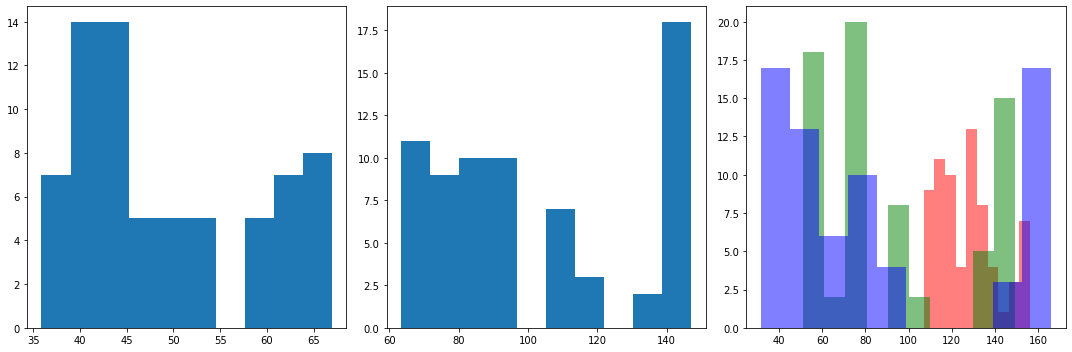

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(all_contrast)
plt.subplot(1,3,2)
plt.hist(all_brightness)
plt.subplot(1,3,3)
plt.hist(all_rbg[:,0],color='r',alpha=.5)
plt.hist(all_rbg[:,1],color='g',alpha=.5)
plt.hist(all_rbg[:,2],color='b',alpha=.5)

plt.tight_layout()

In [21]:
all_rbg.mean(axis=0).astype(int)

array([127,  92,  85])

In [22]:
all_contrast.mean().astype(int)

49

In [23]:
all_brightness.mean().astype(int)

101

In [24]:
# contrast_target = 50
# brightness_target = 100
# ctargets = np.array([100,80,80])

In [25]:
# contrast_target = 50
# brightness_target = 100
# ctargets = np.array([120,80,80])

In [26]:
## GOOD VALUES
contrast_target = 50
brightness_target = 125
ctargets = np.array([125,90,85])

In [27]:
# ## GOOD VALUES
# contrast_target = 50
# brightness_target = 125
# ctargets = np.array([100,100,100])

In [30]:
run_norm = True
do_plot = False

ofdir = '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/'
safe_mkdir(ofdir)

if run_norm:
    #for f in np.arange(0,70,10):
    #for f in [0]:
    for f in tqdm(range(len(files))):
        
        fn = files[f]
        videodata = load_video(fn)
        frame = videodata[0,:,:,:]
        
        videodata = tint_video(videodata,ctargets)
        
        for i in range(25):        
            contrast = videodata[0,:,:,:].mean(axis=-1).std()
            brightness = videodata[0,:,:,:].mean()
            videodata = contrast_video(videodata,contrast_target/contrast)
            videodata = brighten_video(videodata,brightness_target/brightness)
            
        
        #videodata = tint_video(videodata,ctargets)

                
        save_video(videodata,fn.replace(indir,ofdir))

        frame_copy = videodata[0,:,:,:]

        contrast = videodata[0,:,:,:].mean(axis=-1).std()
        brightness = videodata[0,:,:,:].mean()
        
        if do_plot:
            ncols = 7
            plt.figure(figsize=(5*ncols,ncols));i=0;
            i+=1;plt.subplot(1,ncols,i);plt.imshow(frame);plt.xticks([]);plt.yticks([]);plt.title('Orig Frame');
            i+=1;plt.subplot(1,ncols,i);plt.imshow(frame_copy);plt.xticks([]);plt.yticks([]);plt.title('new frame');

            #i+=1;plt.subplot(1,ncols,i);plt.imshow(face_square);plt.xticks([]);plt.yticks([]);plt.title('Orig Face');
            #i+=1;plt.subplot(1,ncols,i);plt.imshow(new_face);plt.xticks([]);plt.yticks([]);plt.title('New Face');


            fontsize=40
            i+=1;plt.subplot(1,ncols,i);
            #plt.text(.5,1,f'C| {get_contrast(get_face(frame))}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            #plt.text(.5,2,f'B| {get_brightness(get_face(frame))}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.5,1,f'C| {get_contrast(frame)}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.5,2,f'B| {get_brightness(frame)}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);

            old_c = get_mean_rbg(frame).astype(np.uint8)
            plt.text(.15,1.5,f'{old_c[0]}/{old_c[1]}/{old_c[0]}',fontsize=fontsize*.75);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);

            plt.title('Original frame')


            i+=1;plt.subplot(1,ncols,i);
            #plt.text(.5,1,f'C| {get_contrast(get_face(videodata[0,:,:,:]))}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            #plt.text(.5,2,f'B| {get_brightness(get_face(videodata[0,:,:,:]))}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.5,1,f'C| {get_contrast(videodata[0,:,:,:])}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.5,2,f'B| {get_brightness(videodata[0,:,:,:])}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);        
            new_c = get_mean_rbg(videodata[0,:,:,:]).astype(np.uint8)
            plt.text(.15,1.5,f'{new_c[0]}/{new_c[1]}/{new_c[2]}',fontsize=fontsize*.75);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);

            plt.title('New frame')

            i+=1;plt.subplot(1,ncols,i);
            plt.text(.5,1,f'C| {contrast_target}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.5,2,f'B| {brightness_target}',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.15,1.5,f'{ctargets[0]}/{ctargets[1]}/{ctargets[2]}',fontsize=fontsize*.75);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.title('Target values')

            i+=1;plt.subplot(1,ncols,i);
            delta_c = (abs(contrast_target-contrast)/contrast_target*100).round(2)
            delta_b = (abs(brightness_target-brightness)/brightness_target*100).round(2)
            
            rgb = get_mean_rbg(videodata[0,:,:,:])
            delta_t_r = (abs(ctargets[0]-rgb[0])/ctargets[0]*100).round(2)
            delta_t_g = (abs(ctargets[1]-rgb[1])/ctargets[1]*100).round(2)
            delta_t_b = (abs(ctargets[2]-rgb[2])/ctargets[2]*100).round(2)
            
            plt.text(.5,1,f'C| {delta_c}%',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.5,2,f'B| {delta_b}%',fontsize=fontsize);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.text(.15,1.5,f'{delta_t_r}/{delta_t_g}/{delta_t_b}',fontsize=fontsize*.75);plt.xlim(0,3);plt.ylim(0,3);plt.xticks([]);plt.yticks([]);
            plt.title('Delta')

            plt.tight_layout()
            plt.show()

100%|███████████████████████████████████████████| 70/70 [06:34<00:00,  5.63s/it]


In [31]:
#indir = ofdir
indir = '../stimuli/stimuli_working_dir/stimuli_normed_cb/'
indir = '../stimuli/stimuli_working_dir/stimuli_normed_hue_cb/'
indir = '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
n = len(files)
print(n)
files[0:5]

70


['../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/id1d1.mp4',
 '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/id1d2.mp4',
 '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/id1f1.mp4',
 '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/id1f2.mp4',
 '../stimuli/stimuli_working_dir/stimuli_normed_cb_hue/id1h1.mp4']

In [32]:
all_contrast = []
all_brightness = []
all_rbg = []

for f in tqdm(range(len(files))):
    video_data = load_video(files[f])
    n = video_data.shape[0]

    all_contrast.append( get_contrast(video_data[0,:,:,:]) )
    all_brightness.append( get_brightness(video_data[0,:,:,:]) )
    all_rbg.append( get_mean_rbg(video_data[0,:,:,:]) )
    
all_contrast = np.array(all_contrast)
all_brightness = np.array(all_brightness)
all_rbg = np.array(all_rbg)

100%|███████████████████████████████████████████| 70/70 [00:08<00:00,  8.38it/s]


Text(0.5, 1.0, 'Hue\ncorr w/ ID r=0.36')

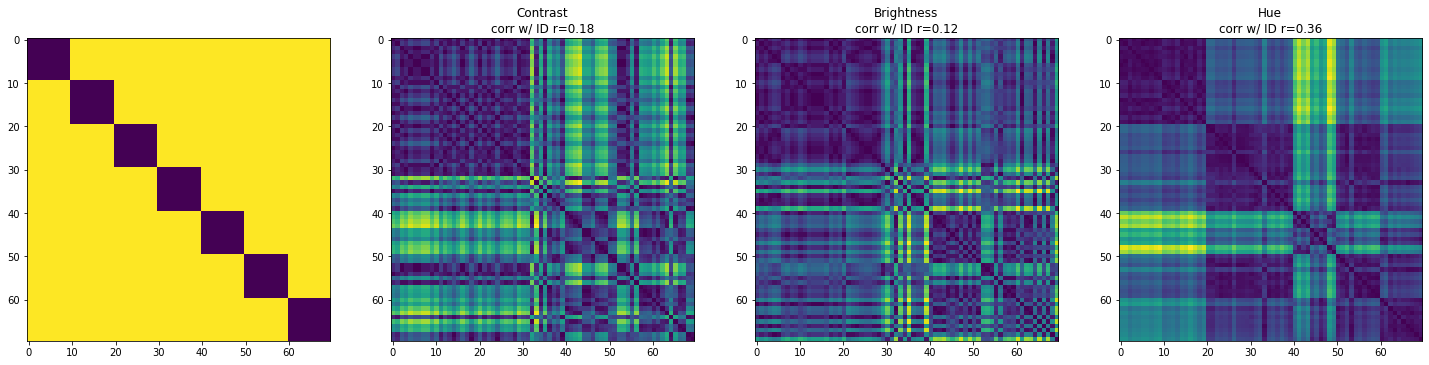

In [33]:
## ID SIMILARITY 
from scipy.spatial.distance import pdist,squareform
from scipy.stats import kendalltau,pearsonr

id_vec = np.hstack([np.repeat(i,10) for i in range(7)])
id_sim = squareform(pdist(id_vec[:,np.newaxis]))
id_sim[id_sim>0] = 1

sim_contrast = squareform(pdist((all_contrast-contrast_target)[:,np.newaxis]))
sim_brightness = squareform(pdist((all_brightness-brightness_target)[:,np.newaxis]))
sim_hue = squareform(pdist(all_rbg-ctargets))

# sim_contrast = squareform(pdist((all_contrast)[:,np.newaxis]))
# sim_brightness = squareform(pdist((all_brightness)[:,np.newaxis]))
# sim_hue = squareform(pdist(all_rbg))

rsa_contrast = kendalltau(get_triu(id_sim),get_triu(sim_contrast))[0]
rsa_brightness = kendalltau(get_triu(id_sim),get_triu(sim_brightness))[0]
rsa_hue = kendalltau(get_triu(id_sim),get_triu(sim_hue))[0]

plt.figure(figsize=(25,10))
plt.subplot(1,4,1);plt.imshow(id_sim);
plt.subplot(1,4,2);plt.imshow(sim_contrast);plt.title(f'Contrast\ncorr w/ ID r={rsa_contrast:.2f}')
plt.subplot(1,4,3);plt.imshow(sim_brightness);plt.title(f'Brightness\ncorr w/ ID r={rsa_brightness:.2f}')
plt.subplot(1,4,4);plt.imshow(sim_hue);plt.title(f'Hue\ncorr w/ ID r={rsa_hue:.2f}')

Text(0.5, 1.0, 'Hue\ncorr w/ ID r=0.45')

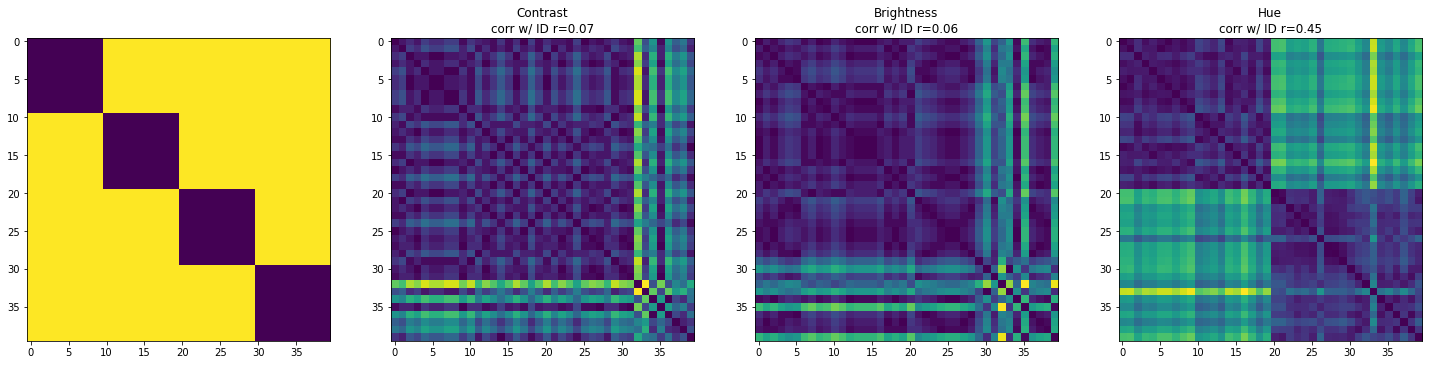

In [34]:
## ID SIMILARITY 
from scipy.spatial.distance import pdist,squareform
from scipy.stats import kendalltau

id_vec = np.hstack([np.repeat(i,10) for i in range(7)])
id_sim = squareform(pdist(id_vec[:,np.newaxis]))
id_sim[id_sim>0] = 1

sim_contrast = squareform(pdist((all_contrast-contrast_target)[:,np.newaxis]))
sim_brightness = squareform(pdist((all_brightness-brightness_target)[:,np.newaxis]))
sim_hue = squareform(pdist(all_rbg-ctargets))


id_sim = id_sim[0:40,:][:,0:40]
sim_contrast = sim_contrast[0:40,:][:,0:40]
sim_brightness = sim_brightness[0:40,:][:,0:40]
sim_hue = sim_hue[0:40,:][:,0:40]


rsa_contrast = kendalltau(get_triu(id_sim),get_triu(sim_contrast))[0]
rsa_brightness = kendalltau(get_triu(id_sim),get_triu(sim_brightness))[0]
rsa_hue = kendalltau(get_triu(id_sim),get_triu(sim_hue))[0]

plt.figure(figsize=(25,10))
plt.subplot(1,4,1);plt.imshow(id_sim);
plt.subplot(1,4,2);plt.imshow(sim_contrast);plt.title(f'Contrast\ncorr w/ ID r={rsa_contrast:.2f}')
plt.subplot(1,4,3);plt.imshow(sim_brightness);plt.title(f'Brightness\ncorr w/ ID r={rsa_brightness:.2f}')
plt.subplot(1,4,4);plt.imshow(sim_hue);plt.title(f'Hue\ncorr w/ ID r={rsa_hue:.2f}')

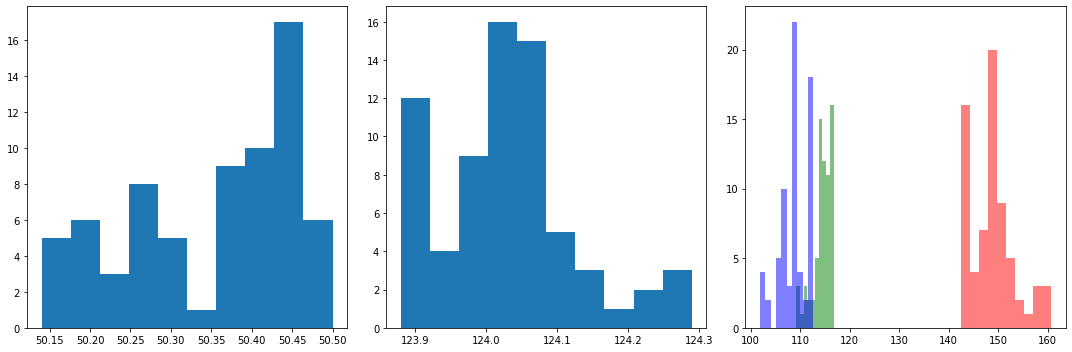

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(all_contrast)
plt.subplot(1,3,2)
plt.hist(all_brightness)
plt.subplot(1,3,3)
plt.hist(all_rbg[:,0],color='r',alpha=.5)
plt.hist(all_rbg[:,1],color='g',alpha=.5)
plt.hist(all_rbg[:,2],color='b',alpha=.5)

plt.tight_layout()

In [33]:
frame_sim = np.corrcoef(np.array([load_video(file)[0,:,:,:].mean(axis=-1).flatten()[::10] for file in tqdm(files)]))

100%|███████████████████████████████████████████| 70/70 [00:08<00:00,  8.28it/s]


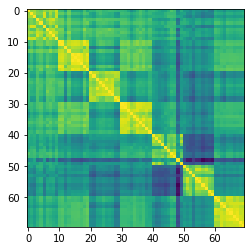

In [34]:
plt.imshow(frame_sim)

In [60]:
np.corrcoef(get_triu(frame_sim),get_triu(1-rgb_dist))

NameError: name 'frame_sim' is not defined

In [36]:
#########
######### PADDING
#########

In [44]:
def pad_frame(img_face,pad_amount=100):
    arr = np.array([np.pad(img_face[:,:,0], (pad_amount, pad_amount), mode='constant'),
    np.pad(img_face[:,:,1], (pad_amount, pad_amount), mode='constant'),
    np.pad(img_face[:,:,2], (pad_amount, pad_amount), mode='constant'),])
    arr = np.swapaxes(arr,0,1)
    arr = np.swapaxes(arr,1,2)
    return arr

In [45]:
def resize_video(video_data,vid_size_target=(512,512)):
    from PIL import Image, ImageEnhance,ImageStat
    import numpy as np
    
    #vid_size_target = np.array((512,512))
    vid_size_target = np.array(vid_size_target)
    vid_size = np.array((video_data.shape[1],video_data.shape[2]))
    nframes = video_data.shape[0]
    nchannels = video_data.shape[-1]
    video_data_new = np.zeros((nframes,vid_size_target[0],vid_size_target[1],nchannels))
    for f in range(nframes):
        video_data_new[f,:,:,:] = np.array(Image.fromarray(video_data[f,:,:,:]).resize(vid_size_target,Image.ANTIALIAS))

    return video_data_new

In [46]:
def pad_video(video_data,pad_amount=250,vid_size_target=(512,512)):
    video_data_padded = np.array([pad_frame(video_data[f,:,:,:],pad_amount=pad_amount) for f in range(video_data.shape[0])])
    video_data_padded_resized = resize_video(video_data_padded,vid_size_target=vid_size_target)
    return video_data_padded_resized

In [63]:
for infn in tqdm(files):
    video_data = load_video(infn)
    for pad in np.arange(0,251,50):
        
        ofdir = f'../stimuli/stimuli_working_dir/stimuli_cropped_normed_crop_{pad}/'
        safe_mkdir(ofdir)
        
        #ofn = infn.replace(indir,ofdir).replace('.mp4',f'_c{pad}.mp4')
        ofn = infn.replace(indir,ofdir)
        video_data_padded = pad_video(video_data,pad_amount=pad,vid_size_target=(512,512))
        save_video(video_data_padded,ofn)

100%|███████████████████████████████████████████| 70/70 [07:21<00:00,  6.30s/it]


In [ ]:
ofdir = './stimuli_normed_cb_rand_crop'
files = [os.path.join(ofdir,file) for file in os.listdir(ofdir) if file.endswith('.mp4')]
files.sort()
n = len(files)
print(n)
files[0:5]

In [ ]:
data = np.array([load_video(file)[0,:,:,:].mean(axis=-1).flatten()[::10] for file in tqdm(files)])

In [ ]:
plt.imshow(np.corrcoef(data))

In [ ]:
ofdir = './stimuli_normed_cb_rand_crop'
files = [os.path.join(ofdir,file) for file in os.listdir(ofdir) if file.endswith('c0.mp4')]
files.sort()
n = len(files)
print(n)
files[0:5]

In [ ]:
data = np.array([load_video(file)[0,:,:,:].mean(axis=-1).flatten()[::10] for file in tqdm(files)])
plt.imshow(np.corrcoef(data))

In [ ]:
Y = 1-get_triu(np.corrcoef(data))
Z = linkage(Y,'ward')
lbls = [file.split('/')[-1].replace('.mp4','')[2] for file in files]
plt.figure(figsize=(25,5))
dendrogram(Z,0,labels=lbls,orientation='top',leaf_font_size=12,color_threshold=.5,leaf_rotation=0);

In [ ]:
np.arange(0,151,50)

In [ ]:
import random
data_r = np.array([load_video(file.replace('_c0.mp4',f'_c{random.choice(np.arange(0,151,50))}.mp4'))[0,:,:,:].mean(axis=-1).flatten()[::10] for file in tqdm(files)])
plt.imshow(np.corrcoef(data_r))

In [ ]:
Y = 1-get_triu(np.corrcoef(data_r))
Z = linkage(Y,'ward')
lbls = [file.split('/')[-1].replace('.mp4','')[2] for file in files]
plt.figure(figsize=(25,5))
dendrogram(Z,0,labels=lbls,orientation='top',leaf_font_size=12,color_threshold=.5,leaf_rotation=0);

In [ ]:
np.corrcoef(get_triu(np.corrcoef(data_r)),get_triu(np.corrcoef(data)))[0,1]

In [ ]:
np.corrcoef(get_triu(np.corrcoef(data_r)),get_triu(np.corrcoef(data)))[0,1]

In [ ]:
# def get_flows(videodata):
    
#     import cv2
    
#     nframes = videodata.shape[0]
#     nframes = videodata.shape[0]
#     flows = []
#     idx_i = np.arange(0,nframes-1)
#     idx_j = np.arange(1,nframes)
#     for i in range(len(idx_i)):
#             frame1 = videodata[idx_i[i],:,:,:].mean(axis=-1).astype(np.int8)
#             frame2 = videodata[idx_j[j],:,:,:].mean(axis=-1).astype(np.int8)
#             flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
#             flows.append(flow)
            
#     return np.array(flows)

In [ ]:
# def get_flow_SS(flows):
#     return ((flows-flows.mean(axis=0))**2).sum(axis=0).mean(axis=-1)

In [ ]:
# def get_magnitude(flows):
#     mags = np.array([cv2.cartToPolar(flows[i,:,:,0],flows[i,:,:,1])[0] for i in range(flows.shape[0])])
#     return mags.mean(axis=0)

In [ ]:
# files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
# file = files[0]
# videodata = load_video(file)

In [ ]:
# #flows_SS = [get_magnitude(get_flows(load_video(file))) for file in tqdm(files)]
# flows_SS = [get_flow_SS(get_flows(load_video(file))) for file in tqdm(files)]

In [ ]:
# flows_SS[0].shape

In [ ]:
# flows_flat = np.array([np.array(flows_SS)[i,:,:].flatten() for i in range(np.array(flows_SS).shape[0])])
# flows_flat.shape

In [ ]:
# plt.imshow(np.corrcoef(flows_flat))

In [ ]:
# Y = 1-get_triu(np.corrcoef(flows_flat))
# Z = linkage(Y,'ward')
# lbls = [file.split('/')[-1].replace('.mp4','')[2:4] for file in files]
# plt.figure(figsize=(25,5))
# dendrogram(Z,0,labels=lbls,orientation='top',leaf_font_size=12,color_threshold=.5,leaf_rotation=0);